In [1]:
# Load in all useful libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats.mstats import gmean
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import pickle
import os
import random
%matplotlib notebook
np.set_printoptions(precision=5, suppress=True) # suppress scientific float notation

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Setting default format for Seaborn/Matplotlib plots
sns.set(context='paper', style="whitegrid", palette='dark', font='sans-serif:Arial', font_scale=1, color_codes=False, rc=None)
sns.set_style("ticks", {"xtick.major.size": 3, "ytick.major.size": 3})
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12})   

In [4]:
Categories = ['0. No effect','1. MT enhanced up-regulation','2. MT enhanced down-regulation','3. MT reduced up-regulation','4. MT reduced down-regulation','5. Level up','6. Level down']
Sample_ids = ['WT_LL_1','WT_LL_2','WT_LL_3','WT_HL_1','WT_HL_2','WT_HL_3','LHCX_LL_1','LHCX_LL_2','LHCX_LL_3','LHCX_HL_1','LHCX_HL_2','LHCX_HL_3']
Factor = ['WT_LL','WT_LL','WT_LL','WT_HL','WT_HL','WT_HL','LHCX_LL','LHCX_LL','LHCX_LL','LHCX_HL','LHCX_HL','LHCX_HL']
Factor_list = ['WT_LL','WT_HL','LHCX_LL','LHCX_HL']

In [5]:
# Read in data
df_counts = pd.read_table('/Volumes/Files/SYSBIO_TOOLS/Data/PT_RNA_Seq/LHCX_result_042817.txt', sep="\t", skiprows=1)
df_counts.columns = ['Gene_id','Chr','Start','End','Strand', 'Length']+Sample_ids 

In [6]:
## First calculate TPM
# Step 1, remove all untranscribed genes (Average <10 counts in all samples)
from tqdm import tqdm
TPM = df_counts[['Gene_id']]
for col in tqdm(Sample_ids):
    Ct = df_counts[col]/df_counts.Length
    TPM[col] = Ct*1e6/np.sum(Ct)
TPM = TPM.set_index('Gene_id')
TPM = TPM[TPM[Sample_ids].mean(axis = 1)>10]
TPM = TPM[:-2] # Remove spikes
# Now use the RNA spike TPM counts to calculate scale factors

100%|██████████| 12/12 [00:00<00:00, 12.28it/s]


In [8]:
# Convert TPM data to 4 features: 0. Grand mean 1. log2FC of wildtype and mutant mean; 
# 2. log2FC WT HL/LL 3. log2FC mutant HL/LL
# Arbitraily set 1.5 fold change as the threshold
from scipy.stats.mstats import gmean
Feature_array = []
for ID in tqdm(TPM.index):
    data = pd.DataFrame({'Value':TPM.loc[ID].values},index=Factor)
    x = []
    for i in Factor_list:
        x.append(gmean(data.loc[i])[0])
    f_0 = np.mean(x)
    f_1 = np.log2(np.mean(x[2:])/np.mean(x[:2]))
    f_2 = np.log2(x[1]/x[0])
    f_3 = np.log2(x[3]/x[2])
    Feature_array.append([f_0,f_1,f_2,f_3])
Feature_array = np.array(Feature_array).astype(np.float32)

100%|██████████| 10054/10054 [00:25<00:00, 398.81it/s]


In [9]:
# Group 1, No significant change in WT and MT
idx_1 = []
for i in range(len(Feature_array)):
    if -0.1<Feature_array[i][2]-Feature_array[i][3]<0.1 and -0.1<Feature_array[i][1]<0.1:
        idx_1.append(i)
print(len(idx_1))

390


In [10]:
# Group 2, the level of up regulation in MT is significantly enhanced
idx_2 = []
for i in range(len(Feature_array)):
    if Feature_array[i][3]-abs(Feature_array[i][2])>0.8 and Feature_array[i][1]>0:
        idx_2.append(i)
len(idx_2)

405

In [11]:
# Group 3, the level of down regulation in MT is significantly enhanced
idx_3 = []
for i in range(len(Feature_array)):
    if Feature_array[i][3]+abs(Feature_array[i][2])<-0.8 and Feature_array[i][1]<0:
        idx_3.append(i)
print(len(idx_3))

64


In [12]:
# Group 4, up-regulation in WT not seen in MT
idx_4 = []
for i in range(len(Feature_array)):
    if -0.1 < Feature_array[i][3] < 0.1 and Feature_array[i][2] > 0.8:
        idx_4.append(i)
print(len(idx_4))

62


In [13]:
# Group 5, down-regulation in WT not seen in MT
idx_5 = []
for i in range(len(Feature_array)):
    if -0.1 < Feature_array[i][3] < 0.1 and Feature_array[i][2] <-0.8 and Feature_array[i][1]:
        idx_5.append(i)
print(len(idx_5))

89


In [14]:
# Group 6, overall up regulated
idx_6 = []
for i in range(len(Feature_array)):
    if -0.5<Feature_array[i][2]-Feature_array[i][3]<0.5 and Feature_array[i][1]>1:
        idx_6.append(i)
print(len(idx_6))

86


In [15]:
# Group 7, overall down regulated
idx_7 = []
for i in range(len(Feature_array)):
    if -0.5<Feature_array[i][2]-Feature_array[i][3]<0.5 and Feature_array[i][1]<-1:
        idx_7.append(i)
print(len(idx_7))

52


In [16]:
############################ Init data for training ################################
choice_index = idx_1+idx_2+idx_3+idx_4+idx_5+idx_6+idx_7
choice = [0]*len(idx_1)+[1]*len(idx_2)+[2]*len(idx_3)+[3]*len(idx_4)+[4]*len(idx_5)+[5]*len(idx_6)+[6]*len(idx_7)
training_data_choice = pd.DataFrame({'Choice':choice},index= TPM.index[choice_index])

In [228]:
# Generate One_hot values for training data
training_one_hot = tf.one_hot(indices = choice,depth=7)
with tf.Session() as sess:
    one_hot_selection = sess.run(training_one_hot)

In [229]:
Gmean_train_input = []
for ID in tqdm(training_data_choice.index):
    data = pd.DataFrame({'Value':TPM.loc[ID].values},index=Factor)
    x = []
    for i in Factor_list:
        x.append(gmean(data.loc[i])[0])
    Gmean_train_input.append(x)
Gmean_train_input = np.array(Gmean_train_input).astype(np.float32)

100%|██████████| 1148/1148 [00:02<00:00, 411.37it/s]


In [230]:
# Check point for all necessary data from above
if os.path.isdir('./Tensorflow/data/') == False:
        os.mkdir('./Tensorflow/data/')
with open('./Tensorflow/data/training_data_choice.pkl','wb') as f:
        pickle.dump(training_data_choice,f)
with open('./Tensorflow/data/one_hot_selection.pkl','wb') as f:
        pickle.dump(one_hot_selection,f) 
with open('./Tensorflow/data/Gmean_train_input.pkl','wb') as f:
        pickle.dump(Gmean_train_input,f)
with open('./Tensorflow/data/choice.pkl','wb') as f:
        pickle.dump(choice,f)
with open('./Tensorflow/data/choice_index.pkl','wb') as f:
        pickle.dump(choice_index,f)

In [6]:
#Load in processed data if already done
training_data_choice = pd.read_pickle('./Tensorflow/data/training_data_choice.pkl')
one_hot_selection = pd.read_pickle('./Tensorflow/data/one_hot_selection.pkl')
Gmean_train_input = pd.read_pickle('./Tensorflow/data/Gmean_train_input.pkl')
choice = pd.read_pickle('./Tensorflow/data/choice.pkl')
choice_index = pd.read_pickle('./Tensorflow/data/choice_index.pkl')

In [17]:
# Before training, first double check the genes of selection
# Get the positions where color should change
Length = [len(idx_1),len(idx_2),len(idx_3),len(idx_4),len(idx_5),len(idx_6),len(idx_7)] # Ori length of each segment of gene #s
xx = np.zeros(len(Length))
xx[0] = len(idx_1)
for i in range(1,len(Length)):
    xx[i] = xx[i-1] + Length[i]
Length = [0.0]+list(xx)

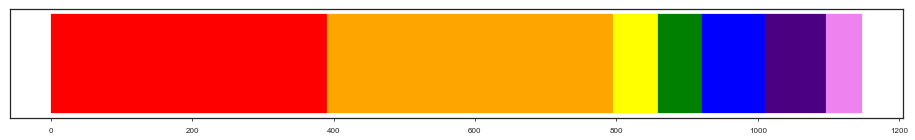

In [18]:
# Here are 1148 genes that we picked 
%matplotlib inline
color_code = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo','violet']
colors = [color_code[i] for i in choice]
f,ax = plt.subplots(1,1,figsize = (16,2))
for i in range(1,len(Length)):
    ax.fill_between([Length[i-1],Length[i]], 0, 0.5,color = color_code[i-1],zorder=0)
ax.yaxis.set_visible(False)

In [19]:
rnd_selection = random.sample(range(len(training_data_choice)),int(len(training_data_choice)*0.5))
x = np.zeros(len(training_data_choice))
for i in range(len(training_data_choice)):
    if i in rnd_selection:
        x[i] = 1

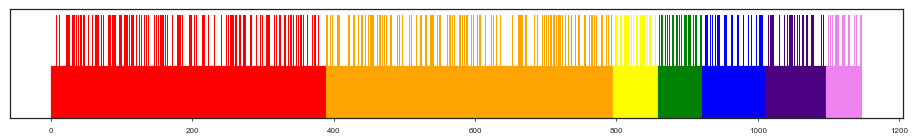

In [20]:
# Select from the featured genes 50% data for training, check if the coverage per category is good
%matplotlib inline
color_code = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo','violet']
colors = [color_code[i] for i in choice]
f,ax = plt.subplots(1,1,figsize = (16,2))
for i in range(len(training_data_choice)):
    ax.bar(range(len(training_data_choice))[i],x[i],color = colors[i])
for i in range(1,len(Length)):
    ax.fill_between([Length[i-1],Length[i]], 0, 0.5,color = color_code[i-1],zorder=0)
ax.yaxis.set_visible(False)

In [9]:
############################ Init data completed ################################
############################ Define Neural network ############################

In [7]:
def add_layer(inputs, in_size, out_size, layer_name, activation_function = None, dropfunc = None, name = 'Hidden'):
    # add one more layer and return the output of this layer
    with tf.name_scope(name):
        layer_var = {'weights':tf.Variable(tf.random_normal([in_size, out_size]),name='W'),
                            'biases':tf.Variable(tf.random_normal([out_size]),name='bias')}
        layer = tf.add(tf.matmul(inputs,layer_var['weights']), layer_var['biases'],name='Wx_plus_b')
            
            # dropout module if needed
        if dropfunc is not None:
            layer = tf.nn.dropout(layer, keep_prob)

        if activation_function is not None:
            layer = activation_function(layer)

        return layer

In [8]:
#Begin constructing Tensorflow neural network
def neural_network_model(xs):
    l1 = add_layer(xs, 4, 300, 'l1', activation_function=tf.nn.relu, dropfunc='Y',name = 'Hidden_layer_relu')
    prediction = add_layer(l1, 300, 7, 'prediction', activation_function=tf.nn.log_softmax, dropfunc=None,name = 'Output')
    return prediction

In [9]:
############################ Training Neural network ############################

# Define varibles
keep_prob = tf.placeholder(tf.float32,name = 'Keep_rate')
xs = tf.placeholder(tf.float32, [None, 4],name='x_input')
ys = tf.placeholder(tf.float32,name = 'y_input')
    
# Building training structure
prediction = neural_network_model(xs) # Function defined above
with tf.name_scope('Cost_function'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=ys, name='Cost_function'))
with tf.name_scope("Train"):    
    optimizer = tf.train.AdamOptimizer(name='Train').minimize(cost)

In [74]:
def Traning(x_input,y_input,keep_rate,iteration,save_path,log_path):    
    import os
    if os.path.isdir(log_path) == False:
            os.mkdir(log_path)
    if os.path.isdir(save_path) == False:
            os.mkdir(save_path)
               
    # Randomly select 50% of the traning dataset for training
    import random
    rnd_selection = random.sample(range(len(x_input)),int(len(x_input)*0.5))
    
    # Traning init    
    with tf.Session() as sess:
        # Init
        sess.run(tf.global_variables_initializer())
        loss = 0
        for step in range(iteration):
            _,c = sess.run([optimizer,cost],feed_dict = {xs:x_input[rnd_selection],ys:y_input[rnd_selection],keep_prob:keep_rate})
            loss += c
        print('loss =', c)

        # Saver     
        saver = tf.train.Saver()
        saver.save(sess, save_path + 'PT_model.ckpt')
        #summary_writer = tf.summary.FileWriter(log_path,graph=sess.graph)
        # Test the model
        prediction_results = tf.equal(tf.argmax(prediction, 1), tf.argmax(ys, 1))
        # Calculate accuracy
        accuracy = tf.reduce_mean(tf.cast(prediction_results, "float")).eval({xs:x_input, ys:y_input,keep_prob:1})
        print("Accuracy:", accuracy)
        return accuracy

In [11]:
# Make predictions using trained and curated data
def Model_prediction(x_input,save_path):
    with tf.Session() as sess:
        ckpt = tf.train.get_checkpoint_state(save_path)
        saver = tf.train.Saver()
        saver.restore(sess,ckpt.model_checkpoint_path)
        prob = sess.run(prediction,feed_dict={xs:x_input,keep_prob:1})
        result = sess.run(tf.argmax(prob,1))
        return result

In [21]:
# Test the model by running it once

# Generate Data_array for all genes - Classify all genes 
Gmean_data_input = []
for ID in tqdm(TPM.index):
    data = pd.DataFrame({'Value':TPM.loc[ID].values},index=Factor)
    x = []
    for i in Factor_list:
        x.append(gmean(data.loc[i])[0])
    Gmean_data_input.append(x)
Gmean_data_input = np.array(Gmean_data_input).astype(np.float32)
with open('./Tensorflow/data/Gmean_data_input.pkl','wb') as f:
        pickle.dump(Gmean_data_input,f)

100%|██████████| 10054/10054 [00:25<00:00, 401.94it/s]


In [22]:
# To save time if you have run the above code already 
Gmean_data_input = pd.read_pickle('./Tensorflow/data/Gmean_data_input.pkl')

In [54]:
# Predic the categories for the other data set - Using trained model
result_real = Model_prediction(x_input = Gmean_data_input,save_path = './Tensorflow/model_log_softmax/')
P_of_selection = np.zeros(len(TPM))
Class_of_selection = []
for i in range(len(TPM)):
    P_of_selection[i] = np.exp(prob_selection[i][result_real[i]])
    Class_of_selection.append(Categories[result_real[i]])

INFO:tensorflow:Restoring parameters from ./Tensorflow/model_log_softmax/PT_model.ckpt


In [ ]:
TPM_class = pd.DataFrame({'Choice':result_real,'Category':Class_of_selection},index = TPM.index)
with open('./Tensorflow/data/TPM_class.pkl','wb') as f:
        pickle.dump(TPM_class,f)

In [58]:
# To save time if you have run the above code already 
TPM_class = pd.read_pickle('./Tensorflow/data/TPM_class.pkl')

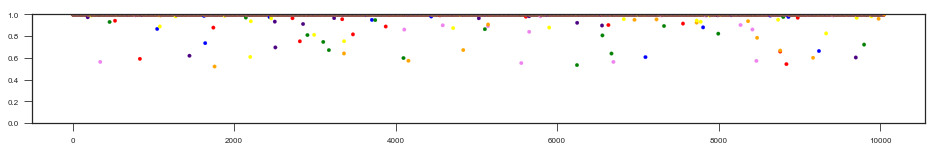

In [132]:
# Check the level of prediction probability 
%matplotlib inline
f,ax = plt.subplots(1,1,figsize = (16,2))
ax.scatter(range(len(TPM)),P_of_selection,marker = '.',c=color_code,s=50)
ax.set_ylim([0,1]);

In [76]:
# If the test run has postive result, start running the model in 100 or more iterations to get simulated pattern distributions
# In each iteration, randomly select 50% from training dataset and use that to classify the entire cDNA libraey dataset
TPM_class_check = pd.DataFrame(index = TPM.index)
accuracy_check = []
for i in range(100):
    print('Iteration:',i)
    ac_check = Traning(x_input = Gmean_train_input,y_input = one_hot_selection,keep_rate = 0.8,iteration = 12000,save_path = './Tensorflow/model_log_softmax/',log_path = './Tensorflow/log/')
    result_real = Model_prediction(x_input = Gmean_data_input,save_path = './Tensorflow/model_log_softmax/');
    name = str('Class'+ str(i))
    TPM_class_check[name] = result_real
    accuracy_check.append(ac_check)

Iteration: 0
loss = 0.0
Accuracy: 0.994774
INFO:tensorflow:Restoring parameters from ./Tensorflow/model_log_softmax/PT_model.ckpt
Iteration: 1
loss = 0.0209797
Accuracy: 0.990418
INFO:tensorflow:Restoring parameters from ./Tensorflow/model_log_softmax/PT_model.ckpt
Iteration: 2
loss = 0.0
Accuracy: 0.991289
INFO:tensorflow:Restoring parameters from ./Tensorflow/model_log_softmax/PT_model.ckpt
Iteration: 3
loss = 0.0
Accuracy: 0.998258
INFO:tensorflow:Restoring parameters from ./Tensorflow/model_log_softmax/PT_model.ckpt
Iteration: 4
loss = 0.194245
Accuracy: 0.999129
INFO:tensorflow:Restoring parameters from ./Tensorflow/model_log_softmax/PT_model.ckpt
Iteration: 5
loss = 0.0350231
Accuracy: 0.995645
INFO:tensorflow:Restoring parameters from ./Tensorflow/model_log_softmax/PT_model.ckpt
Iteration: 6
loss = 0.0082511
Accuracy: 0.997387
INFO:tensorflow:Restoring parameters from ./Tensorflow/model_log_softmax/PT_model.ckpt
Iteration: 7
loss = 0.00887517
Accuracy: 0.995645
INFO:tensorflow:R

loss = 0.00714621
Accuracy: 0.99216
INFO:tensorflow:Restoring parameters from ./Tensorflow/model_log_softmax/PT_model.ckpt
Iteration: 62
loss = 0.0832891
Accuracy: 0.999129
INFO:tensorflow:Restoring parameters from ./Tensorflow/model_log_softmax/PT_model.ckpt
Iteration: 63
loss = 1.24609e-09
Accuracy: 0.989547
INFO:tensorflow:Restoring parameters from ./Tensorflow/model_log_softmax/PT_model.ckpt
Iteration: 64
loss = 0.0
Accuracy: 0.997387
INFO:tensorflow:Restoring parameters from ./Tensorflow/model_log_softmax/PT_model.ckpt
Iteration: 65
loss = 0.0
Accuracy: 0.996516
INFO:tensorflow:Restoring parameters from ./Tensorflow/model_log_softmax/PT_model.ckpt
Iteration: 66
loss = 0.0
Accuracy: 0.994774
INFO:tensorflow:Restoring parameters from ./Tensorflow/model_log_softmax/PT_model.ckpt
Iteration: 67
loss = 0.0
Accuracy: 0.995645
INFO:tensorflow:Restoring parameters from ./Tensorflow/model_log_softmax/PT_model.ckpt
Iteration: 68
loss = 0.000286626
Accuracy: 0.998258
INFO:tensorflow:Restoring

In [89]:
# Reorgnize data from model prediction and put them into dataframe for exporting
colume_name = []



for i in range(7):
    colume_name.append('Selection_'+str(i))
TPM_class_final = pd.DataFrame(index = TPM_class_check.index,columns=colume_name)

for ix in TPM_class_check.index:
    for i in range(7):
        TPM_class_final.loc[ix][colume_name[i]] = TPM_class_check.loc[ix].values.tolist().count(i)

In [105]:
TPM_class_onehot = pd.DataFrame(index = TPM_class_check.index,columns=['Onehot','Prob'])

In [120]:
for ix in TPM_class_onehot.index:
    TPM_class_onehot.loc[ix]['Onehot']=[i for i, j in enumerate(TPM_class_final.loc[ix].values.tolist()) if j == max(TPM_class_final.loc[ix].values)][0]
    TPM_class_onehot.loc[ix]['Prob'] = max(TPM_class_final.loc[ix].values)/100

In [78]:
TPM_class_check.to_pickle('TPM_class_check.pkl')
TPM_class_final.to_pickle('TPM_class_final.pkl')
TPM_class_onehot.to_pickle('TPM_class_onehot.pkl')

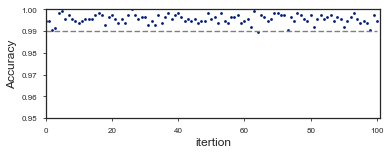

In [28]:
######################### iteration log ###############################
%matplotlib inline
run_log = pd.read_csv('/Users/niudu/Library/Mobile Documents/com~apple~CloudDocs/Dissertation/Jupyter_notebook/System_bio/Tensorflow/100run_log.csv',header=None)
Accuracy_log = [run_log[0][2][10:]]
Accuracy_log +=[run_log[0][i][10:] for i in run_log.index[(run_log.index-2)%4==0]]
f,ax = plt.subplots(1,1,figsize=[6,2])
ax.plot(range(101),Accuracy_log,'.')
ax.plot([0,100],[0.99,0.99],'--',color = 'grey')
# ax.text(90,0.985,'0.99')
ax.set_ylim([0.95,1])
ax.set_xlim([0,101])
ax.set_xlabel('itertion')
ax.set_ylabel('Accuracy')

In [27]:
######################### Load classification result ##########################
TPM_class_final = pd.read_pickle('TPM_class_final.pkl')
TPM_class_onehot = pd.read_pickle('TPM_class_onehot.pkl')

In [30]:
########### Check Onehot result ##########
TPM_class_onehot.loc[Sub_group.index[ID_pick]]

,Onehot,Prob
Gene_id,,
Phatr3_J42768,0,1


In [28]:
########### Check number of genes with given Prob threshold ##########
Sub_group = TPM_class_onehot[TPM_class_onehot.Prob>0.7]
len(Sub_group)

8937

In [31]:
########### Percentage of genes in each category with given Prob threshold ##########

for i in range(7):
    Sub_group = TPM_class_onehot[TPM_class_onehot.Onehot==i]
    len_group = len(Sub_group[Sub_group.Prob>0])
    print(Categories[i],len_group,'--',"{:.0%}".format(len_group/len(TPM_class_onehot)))

0. No effect 4670 -- 46%
1. MT enhanced up-regulation 1488 -- 15%
2. MT enhanced down-regulation 549 -- 5%
3. MT reduced up-regulation 1110 -- 11%
4. MT reduced down-regulation 970 -- 10%
5. Level up 718 -- 7%
6. Level down 549 -- 5%


In [32]:
sub_len = 0
for i in range(7):
    Sub_group = TPM_class_onehot[TPM_class_onehot.Onehot==i]
    len_group = len(Sub_group[Sub_group.Prob<0.6])
    sub_len +=len_group
    
for i in range(7):
    Sub_group = TPM_class_onehot[TPM_class_onehot.Onehot==i]
    len_group = len(Sub_group[Sub_group.Prob<0.6])
    print(len_group,'--',"{:.0%}".format(len_group/sub_len))

print(sub_len,'--',"{:.0%}".format(sub_len/len(TPM_class_onehot)))

186 -- 32%
73 -- 13%
54 -- 9%
70 -- 12%
77 -- 13%
59 -- 10%
63 -- 11%
582 -- 6%


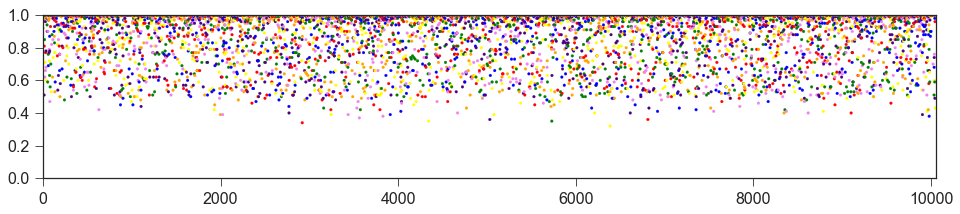

In [34]:
# Overall prob distributions from simulation result
%matplotlib inline
color_code = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo','violet']
colors = [color_code[i] for i in  TPM_class_onehot.Onehot.values.tolist()]
f,ax = plt.subplots(1,1,figsize = (16,3))
ax.scatter(range(len(TPM_class_onehot)),TPM_class_onehot.Prob,marker = '.',c=color_code,s=30)
# ax.plot(range(len(TPM_class_onehot)),sorted(TPM_class_onehot.Prob),color = 'black')
ax.set_xlim([0,len(TPM_class_onehot)]);
ax.set_ylim([0,1]);

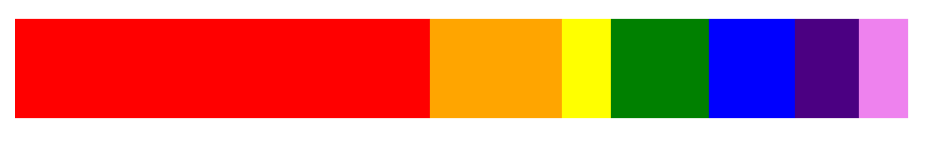

In [35]:
# Over all gene (with Prob) distributions by category
Length = []
for i in range(7):
    Sub_group = TPM_class_onehot[TPM_class_onehot.Onehot==i]
    Length.append(len(Sub_group))
xx = np.zeros(len(Length))
xx[0] = Length[0]
for i in range(1,len(Length)):
    xx[i] = xx[i-1] + Length[i]
Length = [0.0]+list(xx)


# Distribution of the gene expression patterns
%matplotlib inline
color_code = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo','violet']
f,ax = plt.subplots(1,1,figsize = (16,2))
for i in range(1,len(Length)):
    ax.fill_between([Length[i-1],Length[i]], 0, 0.5,color = color_code[i-1],zorder=0)
ax.yaxis.set_visible(False)
ax.set_xlim([0,len(TPM_class_onehot)]);
ax.axis('off');

In [16]:
# Trim data by merging with annotation table
TPM_class_final.columns = Categories

In [17]:
#Pathway annotation using Sarah's data plus Nymark 2009
PT3_DN_Group = pd.read_csv('/Users/niudu/Library/Mobile Documents/com~apple~CloudDocs/Dissertation/Jupyter_notebook/System_bio/Annotation/PT3_Annotation_DN_090617_merged.csv')
PT3_DN_Group = PT3_DN_Group[['Pt3_ID','pt3_KOG_id','Note','Class','Group']].drop_duplicates(subset='Pt3_ID', keep='last').set_index('Pt3_ID')

In [37]:
TPM_class = TPM_class_onehot.merge(PT3_DN_Group,how = 'outer',left_index=True,right_index=True).drop_duplicates()

<IPython.core.display.Javascript object>


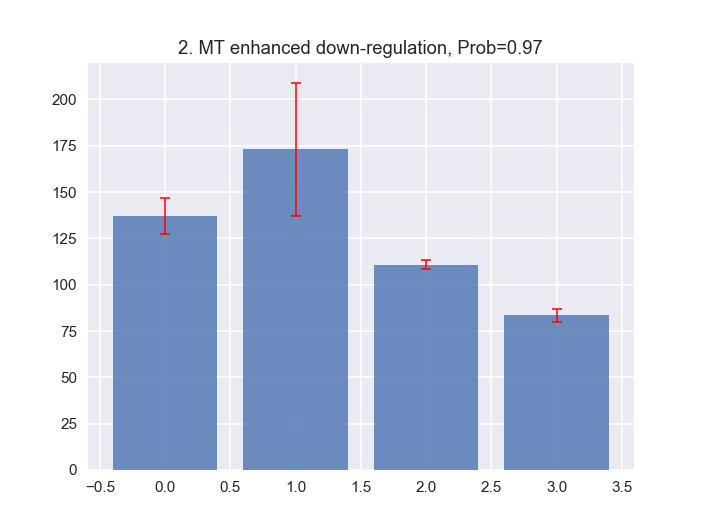

<IPython.core.display.Javascript object>


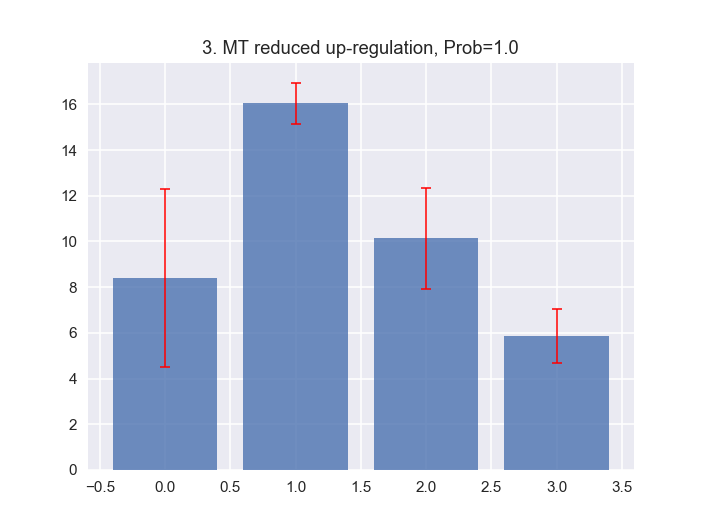

<IPython.core.display.Javascript object>


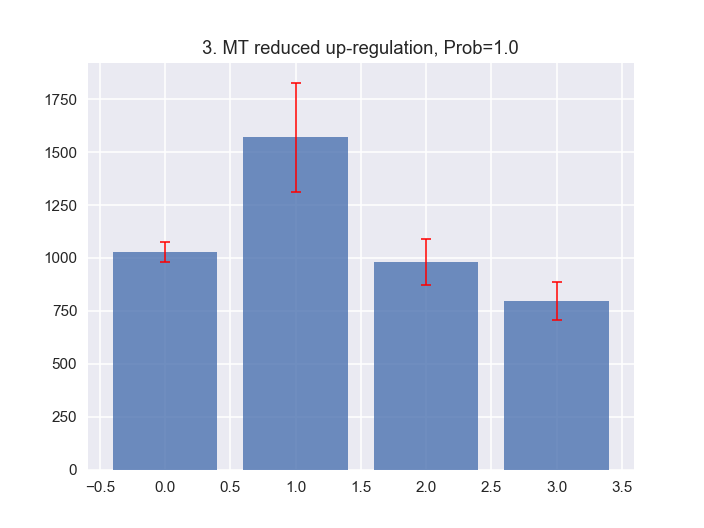

<IPython.core.display.Javascript object>


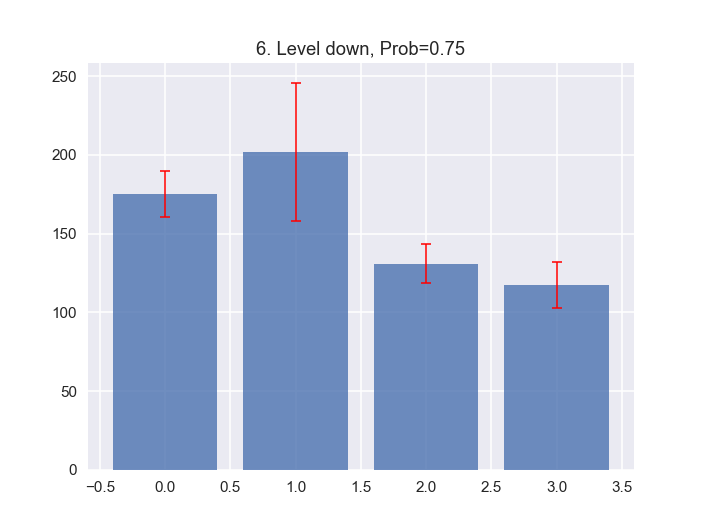

<IPython.core.display.Javascript object>


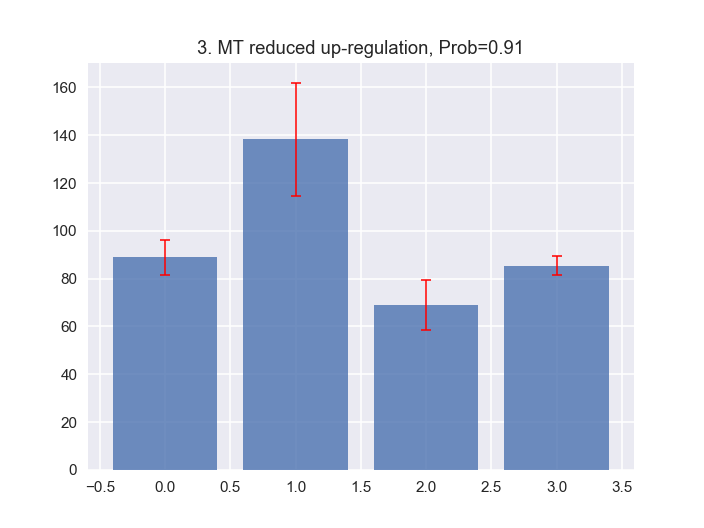

<IPython.core.display.Javascript object>


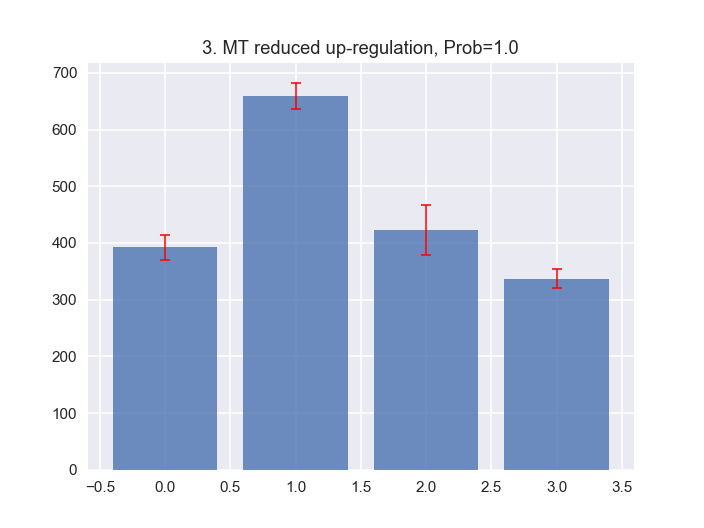

<IPython.core.display.Javascript object>


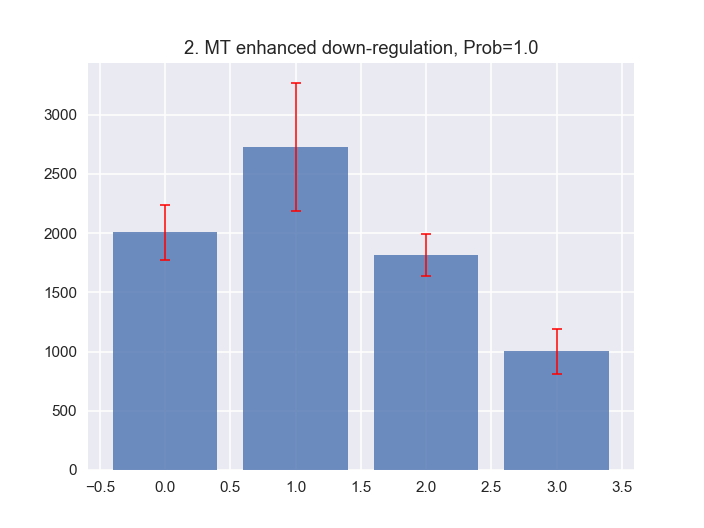

<IPython.core.display.Javascript object>


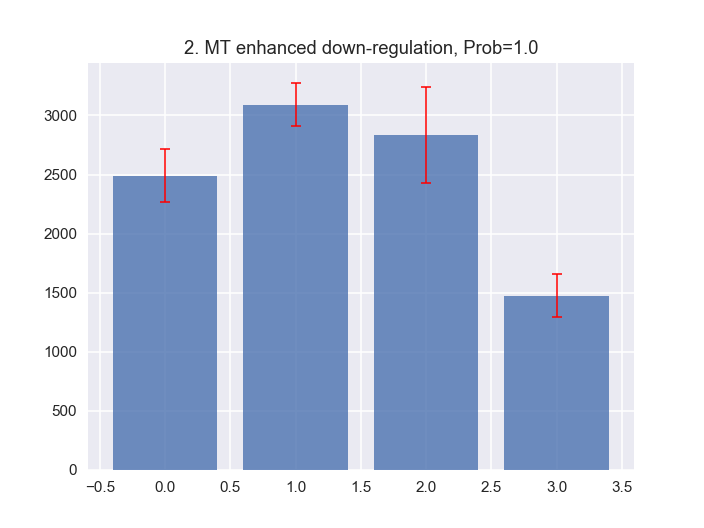

<IPython.core.display.Javascript object>


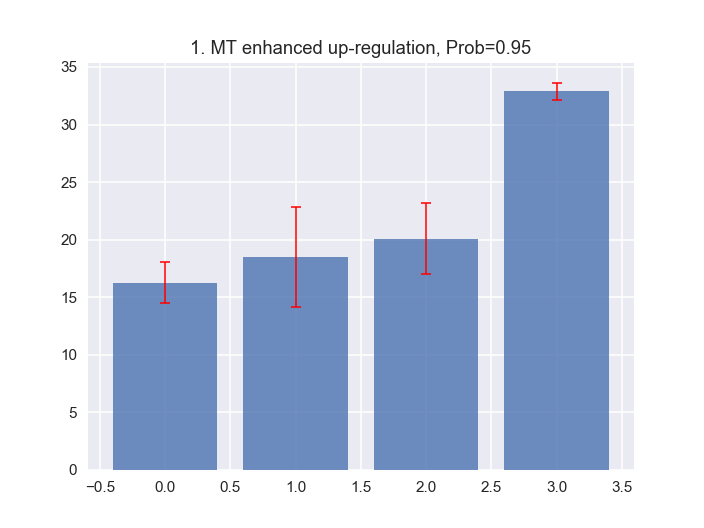

<IPython.core.display.Javascript object>


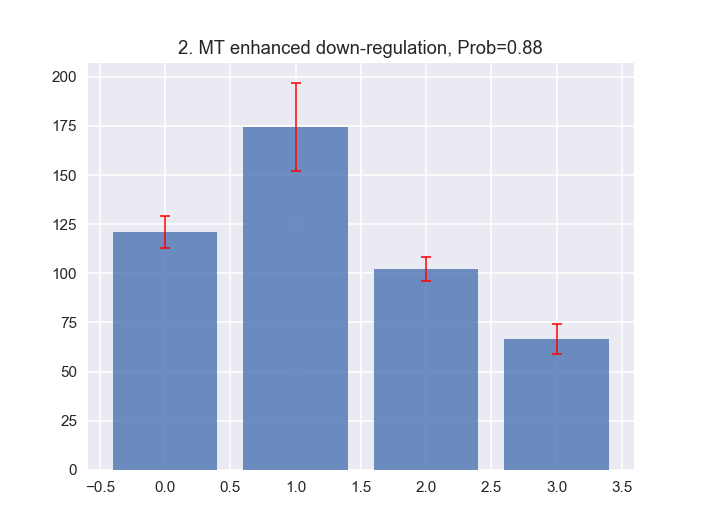

<IPython.core.display.Javascript object>


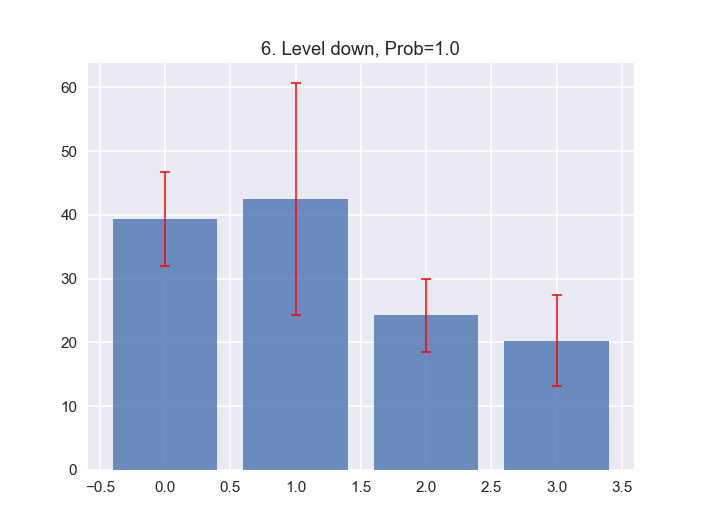

<IPython.core.display.Javascript object>


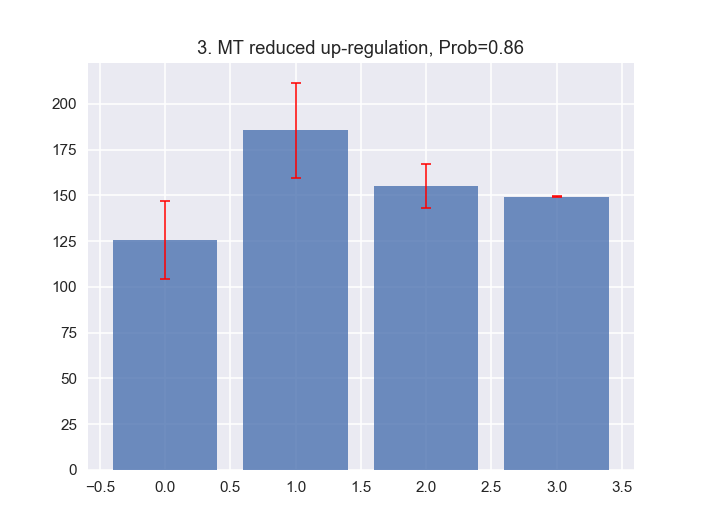

<IPython.core.display.Javascript object>


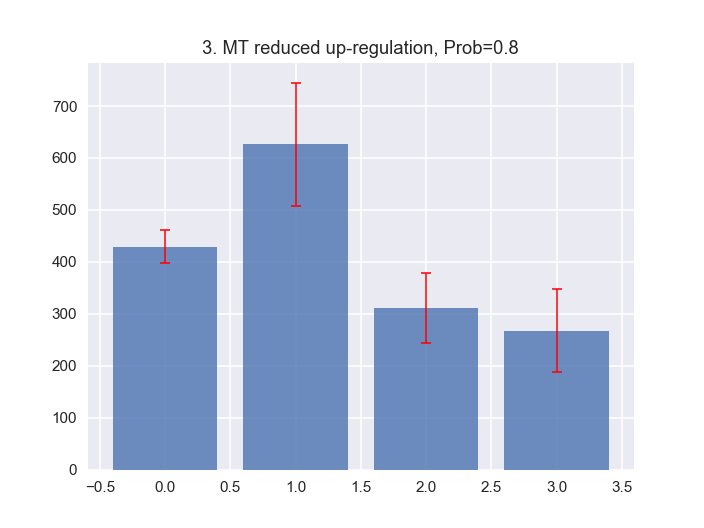

<IPython.core.display.Javascript object>


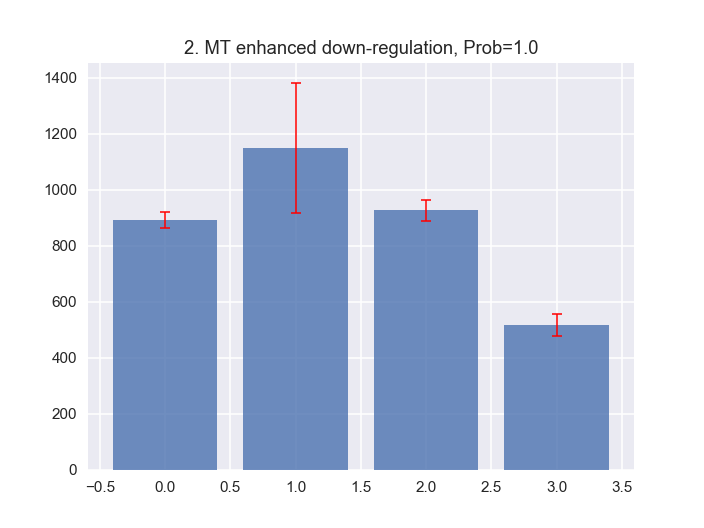

<IPython.core.display.Javascript object>


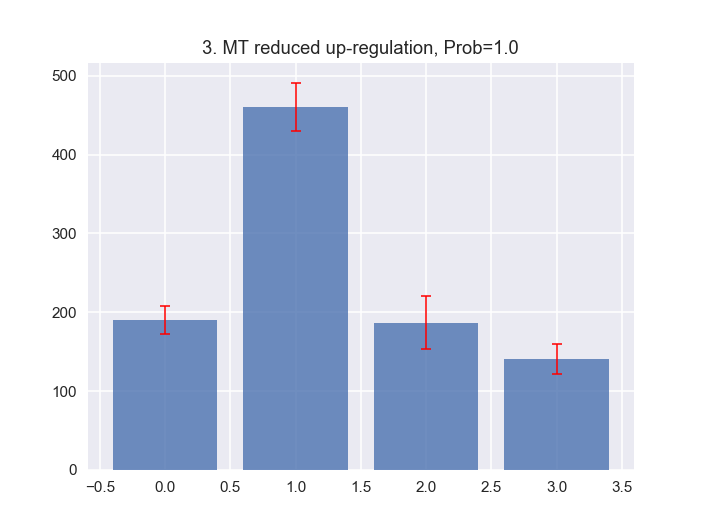

<IPython.core.display.Javascript object>


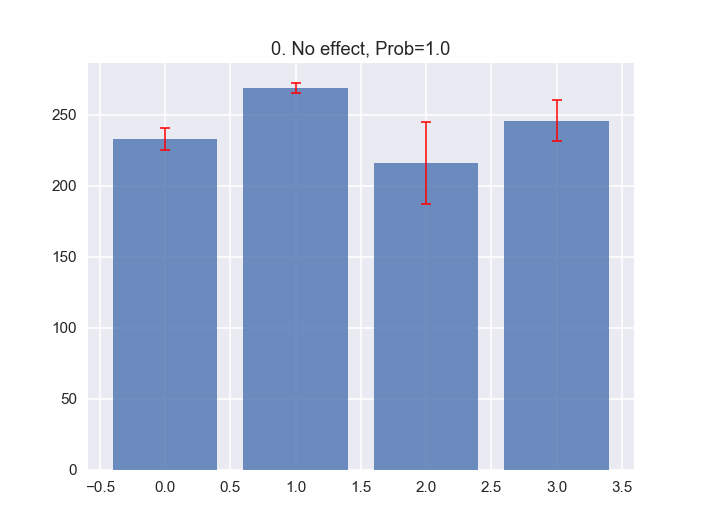

<IPython.core.display.Javascript object>


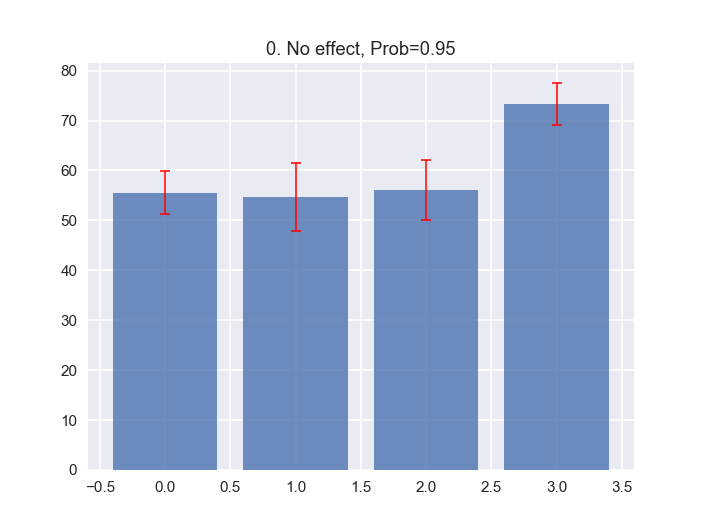

<IPython.core.display.Javascript object>


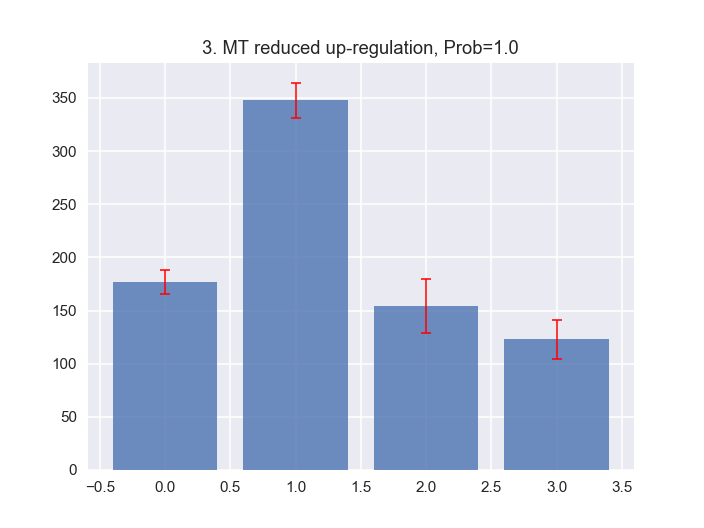

<IPython.core.display.Javascript object>


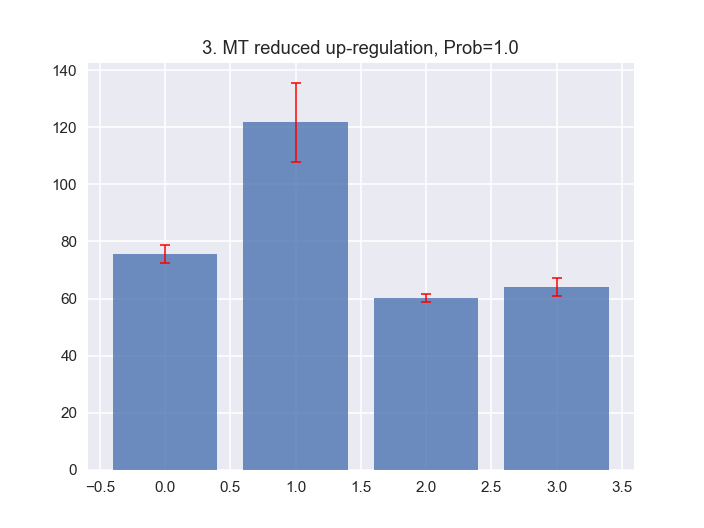

In [30]:
%matplotlib notebook
for ix in TPM_class[TPM_class.Class == 'Translation, ribosomal structure and biogenesis'].index[1:20]:
    Curate_Gene(TPM.loc[[ix]],TPM_class_onehot.loc[[ix]])

In [40]:
TPM_class.to_pickle('/Users/niudu/Library/Mobile Documents/com~apple~CloudDocs/Dissertation/Jupyter_notebook/Chapter_III_LHCX/Transcriptome/TPM_class.pkl')
TPM.to_pickle('/Users/niudu/Library/Mobile Documents/com~apple~CloudDocs/Dissertation/Jupyter_notebook/Chapter_III_LHCX/Transcriptome/TPM.pkl')


In [55]:
# Example exporting final result
TPM_class[TPM_class.Onehot == 1].drop_duplicates().to_csv('/Users/niudu/Desktop/Mutant_up.csv')